In [56]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

In [57]:
RANDOM_SEED = 42

In [83]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2, n_classes=2
)

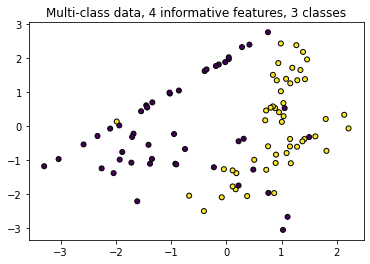

In [84]:
import matplotlib.pyplot as plt
plt.title("Multi-class data, 4 informative features, 3 classes", fontsize="large")
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train).float())

X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([67, 4]) torch.Size([67])
torch.Size([33, 4]) torch.Size([33])


In [63]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [64]:
net = Net(X_train.shape[1])

In [65]:
criterion = nn.BCELoss()

In [66]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [68]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [69]:
net = net.to(device)

criterion = criterion.to(device)

In [70]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [71]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

In [72]:
def will_it_rain(rainfall, humidity, rain_today, pressure):
  t = torch.as_tensor([rainfall, humidity, rain_today, pressure]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

In [73]:
will_it_rain(rainfall=10, humidity=10, rain_today=True, pressure=2)

True